# Import packages
A package (or library) contains several functions useful in a particular context. Here we import some packages that are generally used in science projects:

- pandas: to manipulate datasets
- numpy: to apply mathematical functions
- matplotlib: to display graphs
- sklearn: contains a lot of machine learning functions and models

In [143]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# import model
from sklearn.linear_model import LinearRegression

from IPython.display import display
pd.options.display.max_columns = None

# Import data
In this part, we use the pandas library in order to import the data into our notebook. The data is then saved into a dataframe called *dataset_bike*

In [117]:
# load data into a dataframe
dataset_bike = pd.read_csv("data.csv",
                           sep = ',',
                           header=0,
                           skip_blank_lines=True,
                           index_col=0)

In [118]:
# print the shape of this dataframe: (nb of rows, nb of columns)
print("The shape of the dataframe is :", dataset_bike.shape)

The shape of the dataframe is : (12166, 15)


In [119]:
# show the first rows of the dataframe
dataset_bike.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  cnt  
0           1  0.24  0.2879  0.81        0.0   16  
1           1  0.22  0.2727  0.80        0.0   40  
2           1  0.22  0.2727  0.80        0.0   32  
3           1  0.24  0.2879  0.75        0.0   13  
4           1  0.24  0.2879  0.75        0.0    1

The goal of this project is to be able to accuratly predict the number of bike that are rented at a given hour. It is the variable **cnt**. To do that, we have access to 2 years of records, including several features such as:
- meteorological measures (temp, atemp, hum, weathersit, windspeed)
- datetime information (hr, holiday, weekday, yr, mth..)

**GOAL raised by your client**: Your model must be able to predict the hourly demand on random samples with a MAE **smaller than 30 bikes**...

MAE: Mean Absolute Error

$$MAE=\frac{1}{n}\sum_{i=0}^n|pred_i- target_i|$$

With:
- $n$: number of samples
- $pred_i$: predicted demand for sample i
- $target_i$: real demand for sample i


In [120]:
# get a basic statistical description of your data
dataset_bike.describe()

instant        season            yr          mnth            hr  \
count  12166.000000  12166.000000  12166.000000  12166.000000  12166.000000   
mean    6083.500000      2.207792      0.289413      5.523015     11.556551   
std     3512.166022      1.081576      0.453509      3.409918      6.911885   
min        1.000000      1.000000      0.000000      1.000000      0.000000   
25%     3042.250000      1.000000      0.000000      3.000000      6.000000   
50%     6083.500000      2.000000      0.000000      5.000000     12.000000   
75%     9124.750000      3.000000      1.000000      8.000000     18.000000   
max    12166.000000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  12166.000000  12166.000000  12166.000000  12166.000000  12166.000000   
mean       0.027371      3.009453      0.684531      1.436791      0.468134   
std        0.163170      2.005088      0.464722      0.651969      0.188544   
min        0.000000      0.000000      0.000000      1.000000      0.020000   
25%        0.000000      1.000000      0.000000      1.000000      0.320000   
50%        0.000000      3.000000      1.000000      1.000000      0.460000   
75%        0.000000      5.000000      1.000000      2.000000      0.620000   
max        1.000000      6.000000      1.000000      4.000000      0.960000   

              atemp           hum     windspeed           cnt  
count  12166.000000  12166.000000  12166.000000  12166.000000  
mean       0.450975      0.627200      0.196178    159.925530  
std        0.169514      0.200268      0.125049    152.575827  
min        0.000000      0.000000      0.000000      1.000000  
25%        0.306800      0.470000      0.104500     34.000000  
50%        0.454500      0.620000      0.194000    119.000000  
75%        0.590900      0.790000      0.283600    234.000000  
max        1.000000      1.000000      0.850700    957.000000

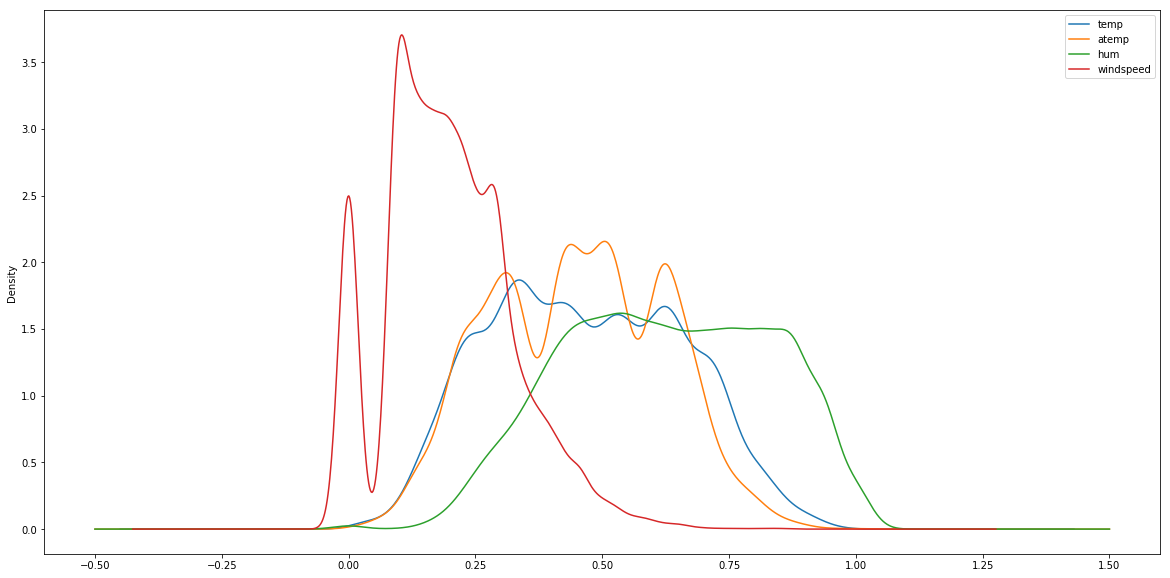

In [121]:
# plot distributions for temp, atemp, hum and windspeed
for variable in ["temp", "atemp", "hum", "windspeed"]:
    dataset_bike[variable].plot.density(legend=True, figsize=(20,10))

Notice that *humidity* is often equal to 0. Let's assume that these measures are actually missing measures. We will try later to replace them.

# Preprocessing
In this part, we will prepare our dataframe so it can be ingested by a machine learning model. The main idea is:
- to get rid or replace missing values: this is called **missing values imputation**
- to keep only numerical variables. Categorical variables have to be encoded: this called **dummification**
- if possible try to create new variables from the ones that already exist. These new variables can improve predictions if they bring *signal*: this is called **feature engineering**
- to split our dataframe in 2 parts. A first one will be used for **training** our model, the other one will be for **testing the performance** of this model

## Imputation of missing values
Here we will assume that if the *windspeed* = 0 this means that the measure is actually missing.
What do we do with these missing values? Several options are possible, you can either:
- delete samples that contains missing values
- replace missing values by the average or median value of the series
- more sophisticated operations (like training another model in order to predict the missing humity)

I suggest to simply replace zeros by the average *windspeed* measure.

In [122]:
dataset_bike_missing_values = dataset_bike.copy()

# Compute average windspeed
mean_windspeed = dataset_bike["windspeed"].mean()

In [123]:
# Assign this value to windspeed when windspeed == 0
dataset_bike_missing_values.loc[dataset_bike_missing_values["windspeed"] == 0, "windspeed"] = mean_windspeed

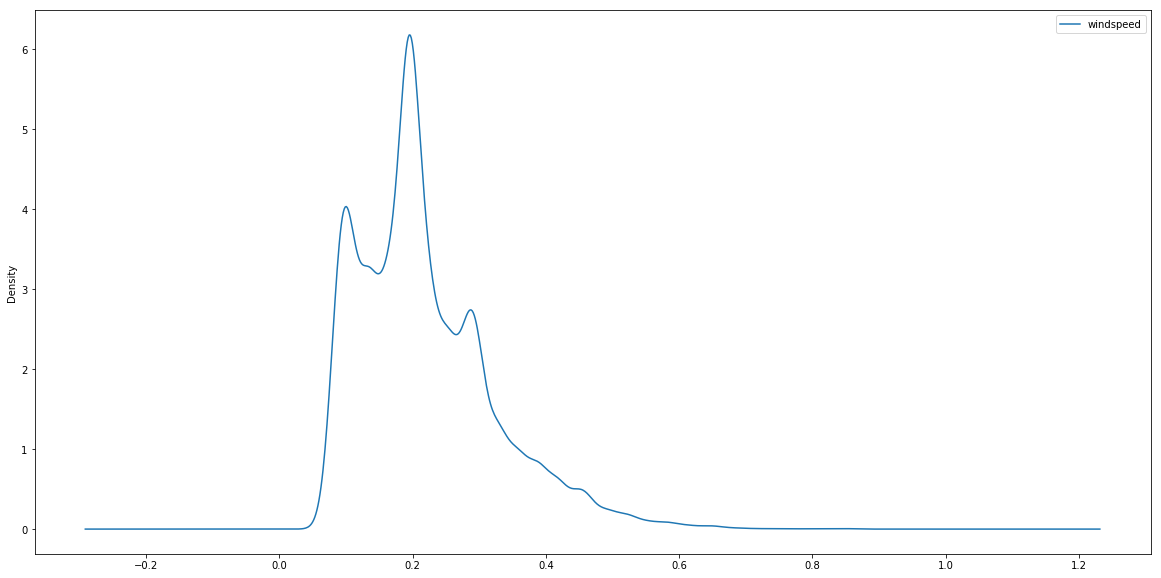

In [124]:
# Plot again the distribution to check that there is no windspeed set to 0
dataset_bike_missing_values["windspeed"].plot.density(legend=True, figsize=(20,10))

## Feature engineering
In this part, we will add new columns to our dataset, and hope that it will bring signal to our model!

In [144]:
dataset_bike_feature_engineering = dataset_bike_missing_values.copy()

### New variable 1: nb of days since 1st record
Let's add a new column to our dataframe that contain the number of days since the day 1...

In [125]:
# First we need to say to Pandas that the dteday column is a date
dataset_bike_feature_engineering["dteday"] = pd.to_datetime(dataset_bike_feature_engineering["dteday"])

In [126]:
# get the value of day 1
min_date = min(dataset_bike_feature_engineering["dteday"])

# create the new column
dataset_bike_feature_engineering["nb_days_since_1st_day"] = (dataset_bike_feature_engineering["dteday"] - min_date).dt.days.astype("int")

In [127]:
# display the last rows of your dataframe
dataset_bike_feature_engineering.tail()

instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
12161    12162 2012-05-26       2   1     5  22        0        6           0   
12162    12163 2012-05-26       2   1     5  23        0        6           0   
12163    12164 2012-05-27       2   1     5   0        0        0           0   
12164    12165 2012-05-27       2   1     5   1        0        0           0   
12165    12166 2012-05-27       2   1     5   2        0        0           0   

       weathersit  temp   atemp   hum  windspeed  cnt  nb_days_since_1st_day  \
12161           1  0.70  0.6667  0.74     0.2537  204                    511   
12162           1  0.70  0.6667  0.74     0.2537  150                    511   
12163           2  0.68  0.6364  0.69     0.1642  137                    512   
12164           1  0.66  0.6212  0.74     0.2239   78                    512   
12165           1  0.64  0.6061  0.73     0.2239   61                    512   

      time_slot    meteo_conditions  
12161     night  average_conditions  
12162     night  average_conditions  
12163     night  perfect_conditions  
12164     night  average_conditions  
12165     night  average_conditions

### New variable 2: split the day in time slots
Now let's split the day in morning, noon, afternoon, evening and night. You will create a new column (feature) that gives you this information (based on *hr*)

In [128]:
# First, we need to describe the mapping between the hour and the part of the day
time_slot_mapping = {
    0: "night",
    1: "night",
    2: "night",
    3: "night",
    4: "night",
    5: "night",
    6: "night",
    7: "morning",
    8: "morning",
    9: "morning",
    10: "morning",
    11: "morning",
    12: "noon",
    13: "noon",
    14: "afternoon",
    15: "afternoon",
    16: "afternoon",
    17: "afternoon",
    18: "afternoon",
    19: "evening",
    20: "evening",
    21: "evening",
    22: "night",
    23: "night"    
}

In [129]:
## create the new variable, and apply the mapping on the hour
dataset_bike_feature_engineering["time_slot"] = dataset_bike_feature_engineering["hr"].map(time_slot_mapping)

In [130]:
dataset_bike_feature_engineering.head()

instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1 2011-01-01       1   0     1   0        0        6           0   
1        2 2011-01-01       1   0     1   1        0        6           0   
2        3 2011-01-01       1   0     1   2        0        6           0   
3        4 2011-01-01       1   0     1   3        0        6           0   
4        5 2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  cnt  nb_days_since_1st_day  \
0           1  0.24  0.2879  0.81   0.196178   16                      0   
1           1  0.22  0.2727  0.80   0.196178   40                      0   
2           1  0.22  0.2727  0.80   0.196178   32                      0   
3           1  0.24  0.2879  0.75   0.196178   13                      0   
4           1  0.24  0.2879  0.75   0.196178    1                      0   

  time_slot    meteo_conditions  
0     night  average_conditions  
1     night  average_conditions  
2     night  average_conditions  
3     night  average_conditions  
4     night  average_conditions

### New variable 3: meteo attractiveness
I imagine that it is more motivating to use a bike on a sunny and warm day than on the rainy and cold day. As a consequence, let's create a new feature that would give the information "perfect_conditions", "worst_conditions" or "average_conditions" depending on the meteorological features (*temp, hum, weathersit, windspeed*). This is totally subjective, but maybe this will improve your model. Let's see

In [131]:
# define the function that returns the motivation depending on meteo conditions
def get_meteo_attractiveness(weather_situation, temperature, humidity, windspeed):
    if (weather_situation in [1,2]) and (temperature > 0.3) and (humidity < 0.7) and (windspeed < 0.6):
        return "perfect_conditions"
    elif (weather_situation in [3,4]) and ((temperature < 0.3) or (humidity > 0.7) or (windspeed > 0.7)):
        return "worst_conditions"
    else:
        return "average_conditions"

In [133]:
# create the new column and apply the function
dataset_bike_feature_engineering["meteo_conditions"] = \
    dataset_bike_feature_engineering.\
            apply(lambda row: get_meteo_attractiveness(row["weathersit"],
                                                       row['temp'],
                                                       row['hum'],
                                                       row['windspeed']),axis=1)

In [134]:
dataset_bike_feature_engineering.head()

instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1 2011-01-01       1   0     1   0        0        6           0   
1        2 2011-01-01       1   0     1   1        0        6           0   
2        3 2011-01-01       1   0     1   2        0        6           0   
3        4 2011-01-01       1   0     1   3        0        6           0   
4        5 2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  cnt  nb_days_since_1st_day  \
0           1  0.24  0.2879  0.81   0.196178   16                      0   
1           1  0.22  0.2727  0.80   0.196178   40                      0   
2           1  0.22  0.2727  0.80   0.196178   32                      0   
3           1  0.24  0.2879  0.75   0.196178   13                      0   
4           1  0.24  0.2879  0.75   0.196178    1                      0   

  time_slot    meteo_conditions  
0     night  average_conditions  
1     night  average_conditions  
2     night  average_conditions  
3     night  average_conditions  
4     night  average_conditions

## Dummification

The dummification is a function that transpose a column to a set of columns in a dataframe, such as:

| Column |
|------|
|   a  |
|   b  |
|   b  |
|   c  |
|   a  |

becomes 

| is_a | is_b | is_c |
|------|------|------|
|   1  |   0  |   0  |
|   0  |   1  |   0  |
|   0  |   1  |   0  |
|   0  |   0  |   1  |
|   1  |   0  |   0  |

All the textual variables have to be dummified in order to keep only numerical values in our dataset. We can also apply dummification to numerical variables if there is not a relational ranking among the values. Here we will apply this function to *weathersit* and *season*

In [135]:
dataset_bike_dummified = dataset_bike_feature_engineering.copy()

# define a list that contain all the columns to dummify
columns_to_dummify = ["time_slot", "meteo_conditions", "weathersit", "season"]

# Now let's apply dummification
for col in columns_to_dummify:
    dataset_bike_dummified = pd.concat([dataset_bike_dummified, pd.get_dummies(dataset_bike_feature_engineering[col], prefix=col)], axis=1)
    dataset_bike_dummified = dataset_bike_dummified.drop(col, axis=1)

In [136]:
dataset_bike_dummified.head()

instant     dteday  yr  mnth  hr  holiday  weekday  workingday  temp  \
0        1 2011-01-01   0     1   0        0        6           0  0.24   
1        2 2011-01-01   0     1   1        0        6           0  0.22   
2        3 2011-01-01   0     1   2        0        6           0  0.22   
3        4 2011-01-01   0     1   3        0        6           0  0.24   
4        5 2011-01-01   0     1   4        0        6           0  0.24   

    atemp   hum  windspeed  cnt  nb_days_since_1st_day  time_slot_afternoon  \
0  0.2879  0.81   0.196178   16                      0                    0   
1  0.2727  0.80   0.196178   40                      0                    0   
2  0.2727  0.80   0.196178   32                      0                    0   
3  0.2879  0.75   0.196178   13                      0                    0   
4  0.2879  0.75   0.196178    1                      0                    0   

   time_slot_evening  time_slot_morning  time_slot_night  time_slot_noon  \
0                  0                  0                1               0   
1                  0                  0                1               0   
2                  0                  0                1               0   
3                  0                  0                1               0   
4                  0                  0                1               0   

   meteo_conditions_average_conditions  meteo_conditions_perfect_conditions  \
0                                    1                                    0   
1                                    1                                    0   
2                                    1                                    0   
3                                    1                                    0   
4                                    1                                    0   

   meteo_conditions_worst_conditions  weathersit_1  weathersit_2  \
0                                  0             1             0   
1                                  0             1             0   
2                                  0             1             0   
3                                  0             1             0   
4                                  0             1             0   

   weathersit_3  weathersit_4  season_1  season_2  season_3  season_4  
0             0             0         1         0         0         0  
1             0             0         1         0         0         0  
2             0             0         1         0         0         0  
3             0             0         1         0         0         0  
4             0             0         1         0         0         0

## Split Train and Test
Now, you have to choose which features will be taken as input in your model, and which one is the **target**.
Then, let's split your dataframe into train and test. Usually, we use the letter **X** to talk about the features, and **y** for the target

In [137]:
columns_to_remove_in_training = ["instant", "dteday", "atemp", "cnt"]

# let's define a variable that contains the list of features to keep for the model
features_training = [col for col in dataset_bike_dummified.columns if col not in columns_to_remove_in_training]

target_feature = "cnt"


In [138]:
features_training

['yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'nb_days_since_1st_day',
 'time_slot_afternoon',
 'time_slot_evening',
 'time_slot_morning',
 'time_slot_night',
 'time_slot_noon',
 'meteo_conditions_average_conditions',
 'meteo_conditions_perfect_conditions',
 'meteo_conditions_worst_conditions',
 'weathersit_1',
 'weathersit_2',
 'weathersit_3',
 'weathersit_4',
 'season_1',
 'season_2',
 'season_3',
 'season_4']

In [139]:
# split your dataframe randomly in order to keep 80% of the samples for training, 20% for testing (also called evaluation).
X_train, X_test, y_train, y_test = train_test_split(dataset_bike_dummified[features_training],
                                                    dataset_bike_dummified[target_feature],
                                                    test_size=0.2, random_state= 1234)

# print the shapes
print("Shape X_train :", X_train.shape)
print("Shape X_test :", X_test.shape)
print("Shape y_train :", y_train.shape)
print("Shape y_test :", y_test.shape)

Shape X_train : (9732, 26)
Shape X_test : (2434, 26)
Shape y_train : (9732,)
Shape y_test : (2434,)


# Training
Now, your dataframe is ready! You have to choose a model and train it on your data.
Let's take only one type of model for the moment, a simple one: the linear regression.

Training your model is pretty simple thanks to the scikit-learn package! Let's see how it works!

### Model: Mutivariate Linear Regression

In [140]:
# create an "empty" model
lreg = LinearRegression(fit_intercept = False)

# fit (=train) this model. => this is when the model is looking for the best surface in 
# a vectorial space that minimise the distance between samples.
lreg.fit(X_train ,y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

# Evaluation

Great! The model is trained. Now it is time to run an evaluation to see if your model meets the expectations of your client (MAE < 30 bikes)

In [142]:
# Compute predictions on Train
lreg_pred_train = lreg.predict(X_train)
# Compute predictions on Test: this will be used for evaluation
lreg_pred_test = lreg.predict(X_test)

# Evaluate
print("MAE Training = ", mean_absolute_error(lreg_pred_train, y_train))
print("***** MAE Test = ", mean_absolute_error(lreg_pred_test, y_test), " ******")

MAE Training =  73.90759539044477
***** MAE Test =  74.74564429968397  ******


Great new, you improved your previous model! **Unfortunatly, it seems that "MAE Test" is still not small enough to satisfy your client :/.** In the next Notebooks, we will try to use other models in order to improve your score!